In [1]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding
import tensorflow as tf


In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
midi = converter.parse("chpn_op7_1.mid")
midi

<music21.stream.Score 0x7e19c3836aa0>

In [4]:
print(len(midi.flatten().notes))

818


In [ ]:
for element in midi.flatten().notes:
  if isinstance(element , note.Note):
    print(element , element.offset, element.pitch)
  if isinstance(element, chord.Chord):
     print(element, element.offset, '+'.join(str(n) for n in element.normalOrder))


In [6]:
notes = []

for element in midi.flatten().notesAndRests:
  if isinstance(element , note.Note):
    notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch)))
  elif isinstance(element, chord.Chord):
     notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
  elif isinstance(element, note.Rest):
      # Bizarre car main gauche et droite flatten (réunie)
      # Voir autre implémentation
      notes.append((float(element.offset), 0,float(element.seconds), "REST"))

In [ ]:
notes

In [8]:
def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif ("REST" in x):
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note

In [9]:
df = pd.DataFrame(notes, columns=['debut_note','volume','durée(s)', 'pitch/chord'])
df



,debut_note,volume,durée(s),pitch/chord
0,0.00,70.0,0.208333,F4
1,0.00,70.0,0.208333,F2
2,0.50,0.0,0.104167,REST
3,0.50,0.0,0.208333,REST
4,0.75,66.0,0.104167,F4
...,...,...,...,...
1106,309.50,68.0,0.251046,F4
1107,310.00,69.0,1.004184,10
1108,310.00,49.0,1.004184,10+2+5
1109,312.00,0.0,1.800000,REST


In [10]:
df['MIDI Pitch'] = df['pitch/chord'].apply(lambda x: check_pitch(x))


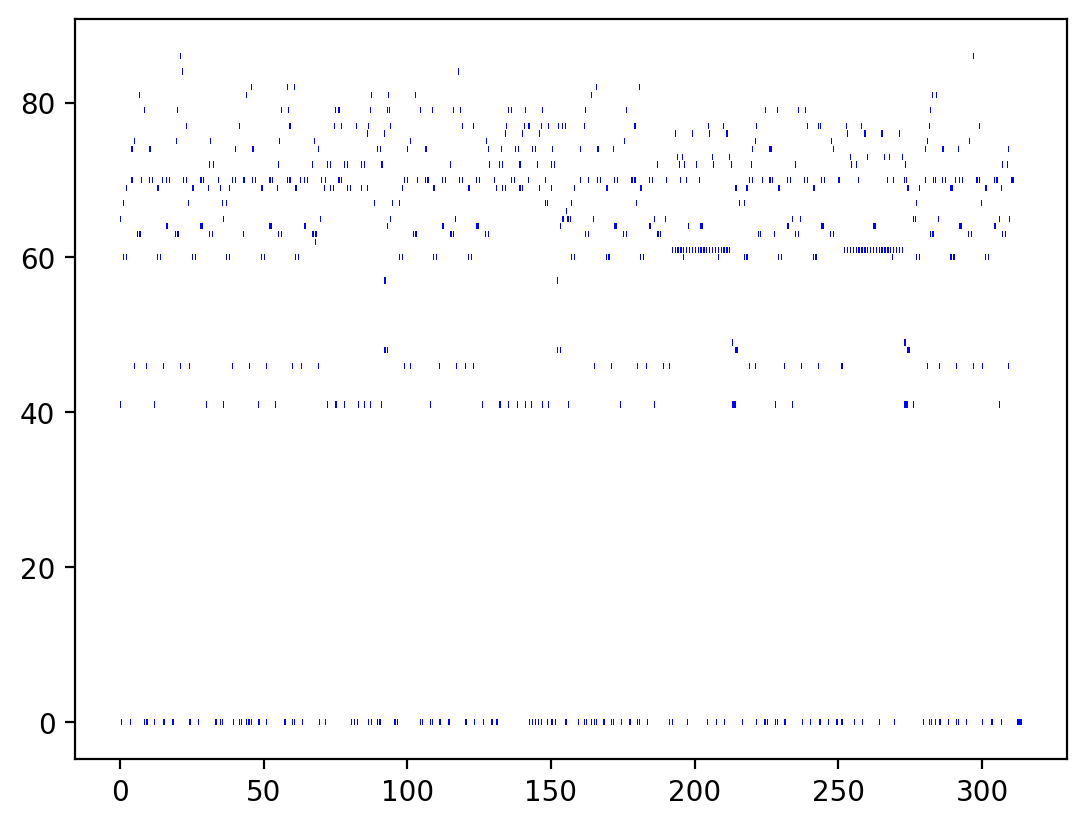

In [11]:
fig, ax = plt.subplots()

for index, row in df.iterrows():
    start = row['debut_note']
    duration = row['durée(s)']
    pitch = row['MIDI Pitch']

    ax.broken_barh([(float(start), float(duration))], (float(pitch) - 0.4, 0.8), facecolors='blue')


In [12]:
df

,debut_note,volume,durée(s),pitch/chord,MIDI Pitch
0,0.00,70.0,0.208333,F4,65
1,0.00,70.0,0.208333,F2,41
2,0.50,0.0,0.104167,REST,0
3,0.50,0.0,0.208333,REST,0
4,0.75,66.0,0.104167,F4,65
...,...,...,...,...,...
1106,309.50,68.0,0.251046,F4,65
1107,310.00,69.0,1.004184,10,70
1108,310.00,49.0,1.004184,10+2+5,70
1109,312.00,0.0,1.800000,REST,0


<Axes: ylabel='Frequency'>

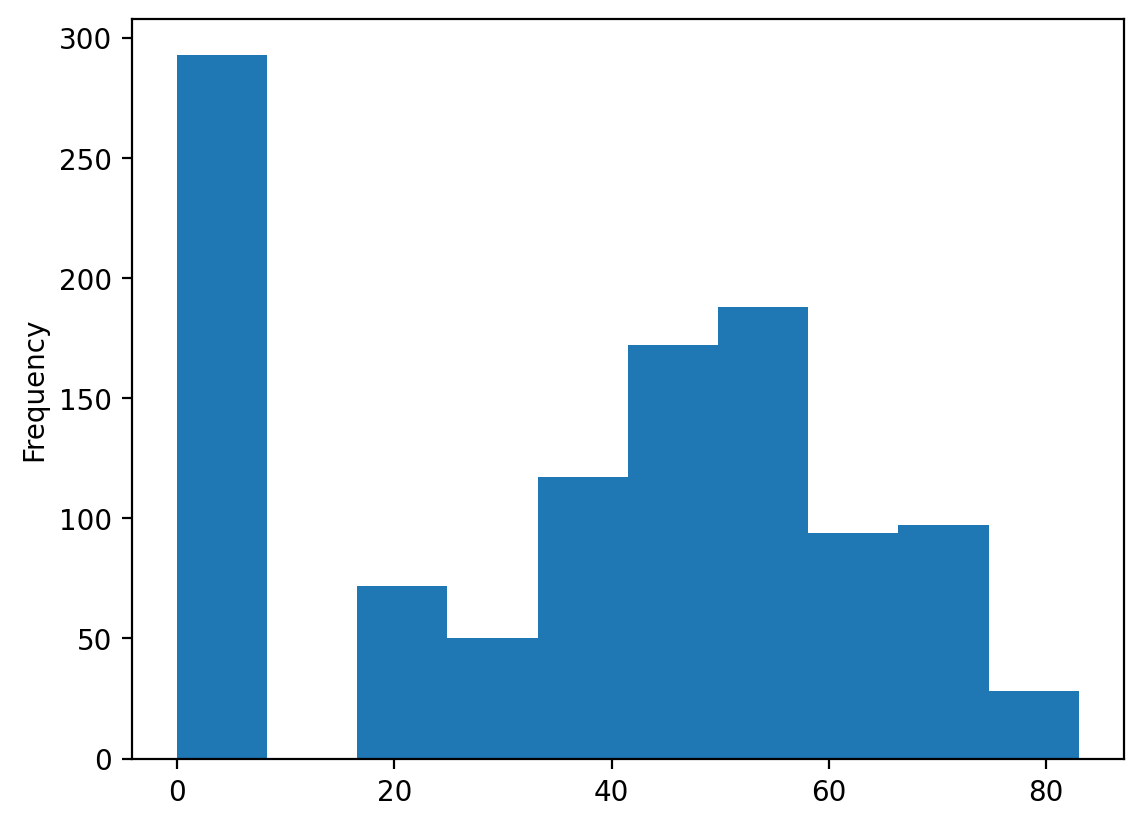

In [13]:
df.volume.plot(kind='hist')
# La vélocité du volume est située entre 0 et 127

<Axes: ylabel='Frequency'>

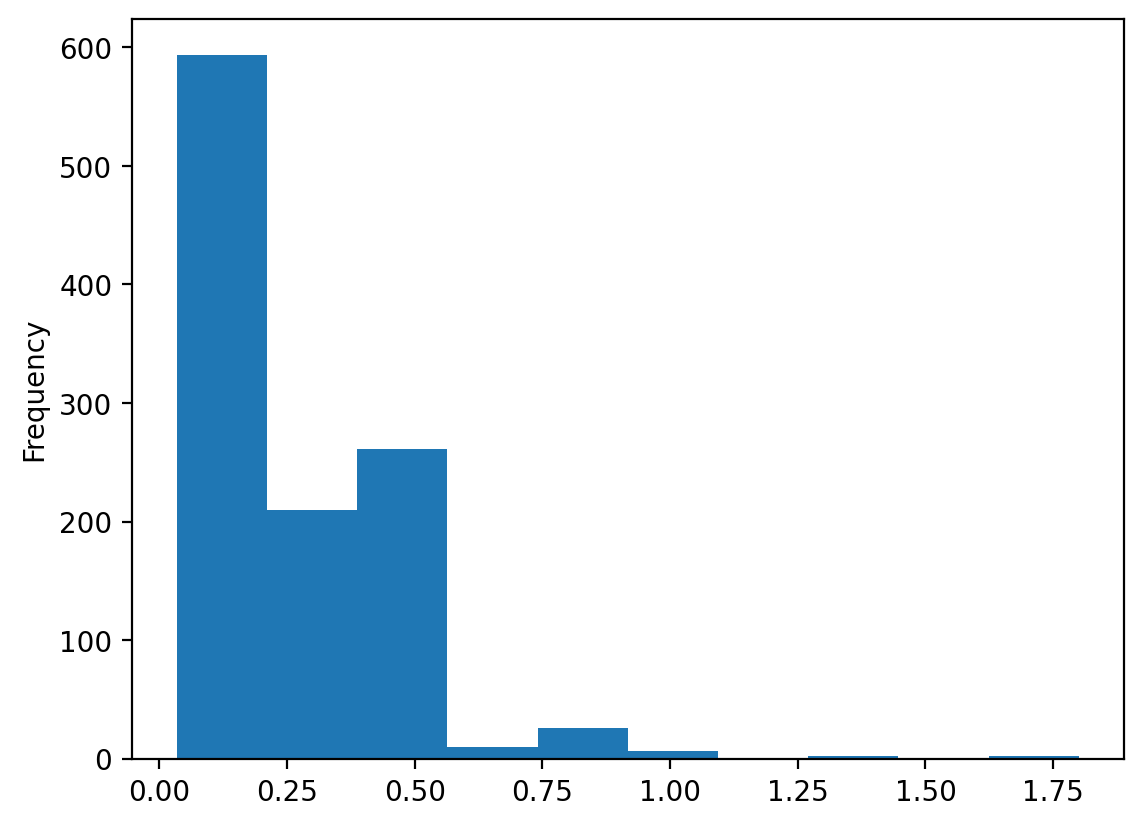

In [14]:
df["durée(s)"].plot(kind="hist")

In [15]:
df

,debut_note,volume,durée(s),pitch/chord,MIDI Pitch
0,0.00,70.0,0.208333,F4,65
1,0.00,70.0,0.208333,F2,41
2,0.50,0.0,0.104167,REST,0
3,0.50,0.0,0.208333,REST,0
4,0.75,66.0,0.104167,F4,65
...,...,...,...,...,...
1106,309.50,68.0,0.251046,F4,65
1107,310.00,69.0,1.004184,10,70
1108,310.00,49.0,1.004184,10+2+5,70
1109,312.00,0.0,1.800000,REST,0


In [16]:
oh_notes =  OneHotEncoder().fit(df[['pitch/chord']])
notes_encoded = oh_notes.transform(df[['pitch/chord']]).toarray()

In [17]:
note_data = notes_encoded
offset_data = df["debut_note"]
volume_data = df["volume"]
duration_data = df["durée(s)"]

In [18]:
sequence_length = 100


def prepare_sequence(data):
  network_input = []
  network_output = []
  # create input sequences and the corresponding outputs
  for i in range(0, len(notes) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)

  n_patterns = len(network_input)
  network_input = numpy.reshape(network_input, (n_patterns, sequence_length, -1))
  network_output = numpy.reshape(network_output, (len(network_output), -1))

  return (network_input, network_output)


In [19]:
input_note, output_note = prepare_sequence(note_data)
input_offset, output_offset = prepare_sequence(offset_data)
input_volume, output_volume = prepare_sequence(volume_data)
input_duration, output_duration = prepare_sequence(duration_data)

In [20]:
print(input_note.shape)
print(output_volume.shape)


(1011, 100, 43)
(1011, 1)


In [40]:
inputNotes_layer = Input(shape=(input_note.shape[1], input_note.shape[2]))
inputNotes = LSTM(
        256,
        input_shape=(input_note.shape[1], input_note.shape[2]),
        return_sequences=True
    )(inputNotes_layer)
inputOffset_layer = Input(shape=(input_offset.shape[1], input_offset.shape[2]))
inputOffset = LSTM(
        256,
        input_shape=(input_offset.shape[1], input_offset.shape[2]),
        return_sequences=True
    )(inputOffset_layer)
inputVolume_layer = Input(shape=(input_volume.shape[1], input_volume.shape[2]))
inputVolume = LSTM(
        256,
        input_shape=(input_volume.shape[1], input_volume.shape[2]),
        return_sequences=True
    )(inputVolume_layer)
inputDuration_layer = Input(shape=(input_duration.shape[1], input_duration.shape[2]))
inputDuration = LSTM(
        256,
        input_shape=(input_duration.shape[1], input_duration.shape[2]),
        return_sequences=True
    )(inputDuration_layer)

inputs = concatenate([inputNotes])
x = LSTM(512, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(512)(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)

outputNotes = Dense(128, activation='relu')(x)
outputNotes = Dense(output_note.shape[1], activation='softmax', name="Note")(outputNotes)

outputOffset = Dense(128, activation='relu')(x)
outputOffset = Dense(output_offset.shape[1], activation='elu', name="Offset")(outputOffset)

outputVolume = Dense(128, activation='relu')(x)
outputVolume = Dense(1, activation='elu', name="Volume")(outputVolume)

outputDuration = Dense(128, activation='relu')(x)
outputDuration = Dense(1, activation='elu', name="Duration")(outputDuration)


#model = Model(inputs=[inputNotes_layer, inputOffset_layer, inputVolume_layer, inputDuration_layer], outputs=[outputNotes, outputOffset, outputVolume, outputDuration])
model = Model(inputs=[inputNotes_layer], outputs=[outputNotes])

#Adam seems to be faster than RMSProp and learns better too
model.compile(loss=['categorical_crossentropy', "mean_squared_error", "mean_squared_error", "mean_squared_error"], optimizer='adam')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 43)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 100, 256)             307200    ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 100, 256)             0         ['lstm[0][0]']                
                                                                                                  
 lstm_6 (LSTM)               (None, 100, 512)             1574912   ['concatenate[0][0]']         
                                                                                              

In [23]:
import os

cp_callback = keras.callbacks.ModelCheckpoint(
    'model_weights_epoch.h5',  # Nom du fichier de sauvegarde avec un espace réservé pour le numéro de l'époque
    save_best_only=True,  # Sauvegarder à chaque époque, pas seulement les meilleurs modèles
    save_weights_only=True,  # Sauvegarder uniquement les poids, pas l'ensemble du modèle
    verbose=1  # Afficher un message lors de la sauvegarde
    )

In [ ]:
input_volume

In [41]:
#model.fit([input_note, input_offset, input_volume, input_duration], [output_note, output_offset, output_volume, output_duration], epochs=400, callbacks=[cp_callback], validation_split=0.2, batch_size=16)
model.fit([input_note], [output_note], epochs=400, callbacks=[cp_callback], validation_split=0.2, batch_size=16)

Epoch 1/400
50/51 [============================>.] - ETA: 0s - loss: 3.2751
Epoch 1: val_loss improved from 16418.25781 to 3.29983, saving model to model_weights_epoch.h5
51/51 [==============================] - 9s 57ms/step - loss: 3.2739 - val_loss: 3.2998
Epoch 2/400
51/51 [==============================] - ETA: 0s - loss: 3.0980
Epoch 2: val_loss improved from 3.29983 to 3.24245, saving model to model_weights_epoch.h5
51/51 [==============================] - 2s 35ms/step - loss: 3.0980 - val_loss: 3.2424
Epoch 3/400
51/51 [==============================] - ETA: 0s - loss: 3.0864
Epoch 3: val_loss improved from 3.24245 to 3.16718, saving model to model_weights_epoch.h5
51/51 [==============================] - 2s 35ms/step - loss: 3.0864 - val_loss: 3.1672
Epoch 4/400
51/51 [==============================] - ETA: 0s - loss: 3.0240
Epoch 4: val_loss improved from 3.16718 to 3.08638, saving model to model_weights_epoch.h5
51/51 [==============================] - 2s 36ms/step - loss: 3.

KeyboardInterrupt: ignored

In [ ]:
import random

In [33]:
model

In [45]:
note_prediction_input = numpy.reshape(input_note[-10], (1, len(input_note[-1]), -1))
index = model.predict([note_prediction_input], verbose=0)
notes_pred = np.zeros(len(pattern_note[0]))
notes_pred[np.argmax(index)] = 1
oh_notes.inverse_transform(notes_pred.reshape(1, -1))

array([['3+5+9']], dtype=object)

In [56]:
prediction_output = []

for i in tqdm(range(500)):
    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))

    prediction = model.predict([note_prediction_input], verbose=0)
    notes_pred = np.zeros(len(pattern_note[0]))
    notes_pred[np.argmax(prediction)] = 1
    result = oh_notes.inverse_transform(notes_pred.reshape(1, -1))



    prediction_output.append(result[0][0])
    pattern_note = numpy.concatenate([pattern_note, prediction])
    pattern_note = pattern_note[1:]


100%|██████████| 500/500 [00:34<00:00, 14.42it/s]


In [63]:
prediction_output

['E4',
 '10+2+5',
 '10+2+5',
 'F4',
 'F2',
 'REST',
 'REST',
 'REST',
 'A4',
 'C5',
 '3+5',
 'E-5',
 '2+3',
 '3+5+9',
 'D5',
 'C5',
 'D5',
 'B-2',
 'REST',
 'REST',
 'F4',
 'B-4',
 '10+2+5',
 'A4',
 'REST',
 'REST',
 'REST',
 'F4',
 'F2',
 'REST',
 'REST',
 'F4',
 'G4',
 '0+3+5',
 'A4',
 '0+3+5',
 'B-4',
 'B-2',
 'REST',
 'REST',
 'C5',
 'D5',
 '10+2+5',
 'E-5',
 'B-2',
 'F5',
 'REST',
 'G5',
 '3',
 'REST',
 'A5',
 '3+7+10',
 '10+0',
 '10+0',
 '10+0',
 '10+0',
 'REST',
 'A5',
 'REST',
 'REST',
 'G5',
 'REST',
 '5+10',
 'REST',
 'B-2',
 'REST',
 'B-5',
 'REST',
 'D5',
 '10+2+5',
 '10+2+5',
 '3+7',
 'REST',
 'F2',
 'REST',
 'G5',
 'REST',
 'A4',
 '0+3+5',
 '0+3+5',
 '10+2',
 'REST',
 'B-2',
 'REST',
 'D5',
 'REST',
 'E4',
 '10+2+5',
 '10+2+5',
 'F4',
 'F2',
 'REST',
 'REST',
 'REST',
 'A4',
 'C5',
 '3+5',
 'E-5',
 '2+3',
 '3+5+9',
 'D5',
 'C5',
 'D5',
 'B-2',
 'REST',
 'REST',
 'F4',
 'B-4',
 '10+2+5',
 'A4',
 'REST',
 'REST',
 'REST',
 'F4',
 'F2',
 'REST',
 'REST',
 'F4',
 'G4',
 '0+3+

In [70]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('+' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    elif('REST'in pattern):
      note_rest = note.Rest()
      note_rest.offset = offset
      output_notes.append(note_rest)
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [26]:
pattern_note = input_note[-1]
pattern_offset = input_offset[-1]
pattern_volume = input_volume[-1]
pattern_duration = input_duration[-1]

In [27]:
import numpy as np
from tqdm import tqdm


In [28]:
prediction_output = []
for note_index in tqdm(range(500)):
    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))

    offset_prediction_input = numpy.reshape(pattern_offset, (1, len(pattern_offset), -1))

    duration_prediction_input = numpy.reshape(pattern_duration, (1, len(pattern_duration), -1))
    volume_prediction_input = numpy.reshape(pattern_volume, (1, len(pattern_volume), -1))

    #print(note_prediction_input.shape)
    #print(offset_prediction_input.shape)
    #print(duration_prediction_input.shape)
    #print(volume_prediction_input.shape)

    prediction = model.predict([note_prediction_input, offset_prediction_input, volume_prediction_input, duration_prediction_input], verbose=0)

    index = prediction[0]
    notes_pred = np.zeros(len(pattern_note[0]))
    notes_pred[np.argmax(index)] = 1
    result = oh_notes.inverse_transform(notes_pred.reshape(1, -1))

    offset = prediction[1]

    volume = (prediction[2])

    duration = (prediction[3])

    prediction_output.append([result, offset, volume, duration])

    pattern_note = numpy.concatenate([pattern_note, index])

    pattern_offset = numpy.append(pattern_offset, offset)
    pattern_duration = numpy.append(pattern_duration, duration)
    pattern_volume = numpy.append(pattern_volume, volume)

    pattern_note = pattern_note[1:]
    pattern_volume = pattern_volume[1:]

    pattern_offset = pattern_offset[1:]
    pattern_duration = pattern_duration[1:]

100%|██████████| 500/500 [00:41<00:00, 12.12it/s]


In [ ]:
prediction_output

In [71]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'